In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import tqdm
import pickle
import matplotlib.pyplot as plt
from Bio.PDB import *
from rdkit import Chem
import os
import time
import shutil
from Bio.SeqUtils import seq1
import gzip
import tarfile
import sys
import random
from rdkit.Chem import rdFreeSASA
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
import urllib
from lxml import etree
import requests as r
from Bio import SeqIO
from io import StringIO
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances

In [2]:
proteins = pickle.load(open("/aloy/home/acomajuncosa/MurD/GitHub/alignment/proteins.pkl", "rb"))
proteins

,uniprot,structures,number of structures,reference structure
0,A0A003,"6KV9_A_NAD_0,6KV9_A_UGA_0,6KVC_A_NAD_0,6KVC_A_...",4,6KV9_A_NAD_0
1,A0A010,"5B00_A_GPP_0,5B00_C_GPP_0,5B00_B_GPP_0",3,5B00_A_GPP_0
2,A0A011,"3VK5_A_FPQ_0,3VK5_B_FPQ_0,3VKA_A_FPQ_0,3VKB_A_...",9,3VKB_B_FPS_0
3,A0A022MQ12,"6SJ2_A_3HA_0,6SJ2_B_3HA_0,6SJ3_A_3HB_0,6SJ3_B_...",6,6SJ2_B_3HA_0
4,A0A022MRT4,"6SIW_A_AMP_0,6SIW_B_AMP_0,6SIX_A_ANP_0,6SIX_B_...",14,6SIX_B_ANP_0
...,...,...,...,...
8735,X5EJW5,"6XJI_C_AGS_0,6XJI_D_AGS_0",2,6XJI_C_AGS_0
8736,X5I2D7,"5H04_A_NAI_0,5WTZ_A_NAD_0,5WU0_A_NAI_0",3,5H04_A_NAI_0
8737,X5IYZ1,"6J38_A_FAD_0,6J38_B_FAD_0,6J39_A_FAD_0,6J39_B_...",6,6J39_A_FAD_0
8738,X5MEI1,"7MPO_A_A3P_0,7MPO_G_A3P_0,7MPO_B_A3P_0,7MPO_E_...",16,7MPO_G_A3P_0


In [3]:
elements = [[uniprot, sts.split(","), "_".join(ref.split("_")[:-1])] for uniprot, sts, ref in zip(proteins['uniprot'], proteins['structures'], proteins['reference structure'])]

In [3]:
# # elements = [i for i in elements if i[0] == 'P02768']
# elements = random.sample(elements, 900)

In [7]:
import sys
sys.path.insert(0, '/aloy/home/acomajuncosa/programs/hpc') #CHANGE THIS PATH TO YOUR HPC PATH!
from hpc import HPC
from sbnb_config import config as cluster_config

scratch_path = "/aloy/scratch/acomajuncosa/MurD/PDB/st_sup" 
script_path = "/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/scripts/superpose_sts_PDB_LIG.py"

cluster_config['queue'] = 'all.q@pac-one104,all.q@pac-one106,all.q@pac-one107,all.q@pac-one108,all.q@pac-one109,all.q@pac-one301,all.q@pac-one401'

ncpus = 2
cluster = HPC(**cluster_config)
njobs = len(elements)

cluster_params = {}
cluster_params['job_name'] = 'st_sup'
cluster_params["jobdir"] = scratch_path
cluster_params["memory"] = ncpus
cluster_params['cpu'] = ncpus
cluster_params["wait"] = False
cluster_params["elements"] = elements
cluster_params["num_jobs"] = len(elements)


singularity_image = "/aloy/home/acomajuncosa/images/2022_06.simg"
command = "singularity exec {} python {} <TASK_ID> <FILE>".format(
singularity_image,
script_path)

cluster.submitMultiJob(command, **cluster_params)

2022-06-16 15:25:04,642 chemicalchecker.util.config.config.Config [DEBUG   ] CC_CONFIG environment variable not set. Using default config file.
2022-06-16 15:25:04,643 chemicalchecker.util.config.config.Config [DEBUG   ] Loading config from: /home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/chemicalchecker/util/config/cc_config.json
2022-06-16 15:25:04,776 hpc.HPC      [DEBUG   ] HPC system to use: sge
2022-06-16 15:25:04,777 hpc.HPC      [DEBUG   ] initializing object sge


module 'matplotlib.font_manager' has no attribute '_rebuild'


/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [73]:
path = "/aloy/scratch/acomajuncosa/MurD/PDB/st_sup"
error = set()

for file in tqdm.tqdm(sorted(os.listdir(path))):
    if '.o' in file:
        with open(os.path.join(path, file), "r") as f:
            for l in f:
                if "error" in l.lower() or "warning" in l.lower():
                    print(file)
                    print(l)
                    error.add(file)
                    break

  7%|▋         | 639/8743 [00:00<00:12, 673.48it/s]

st_sup.o765646.1489
/opt/miniconda3/envs/py37/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:249: PDBConstructionWarning: WARNING: disordered atom found with blank altloc before line 1128.



 40%|████      | 3525/8743 [00:07<00:09, 528.98it/s]

st_sup.o765646.4082
/opt/miniconda3/envs/py37/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:211: PDBConstructionWarning: Negative occupancy in one or more atoms



 56%|█████▌    | 4876/8743 [00:10<00:08, 467.82it/s]

st_sup.o765646.5302
/opt/miniconda3/envs/py37/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:211: PDBConstructionWarning: Negative occupancy in one or more atoms



100%|██████████| 8743/8743 [00:17<00:00, 512.33it/s]


In [4]:
### GET CLUSTERING INFORMATION
path = '/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/reports'
clustering = []
clustering_per_cluster = []

for protein in sorted(os.listdir(path)):
    try:
        clusters = pickle.load(open(os.path.join(path, protein, protein + '.pkl'), "rb"))
        clustering.append([protein, len(set([clusters[i] for i in clusters])), len([clusters[i] for i in clusters])])
        clus_per_clu = Counter([clusters[i] for i in clusters])
        for i in clus_per_clu:
            clustering_per_cluster.append([protein, i, clus_per_clu[i]])
    except:
        print(protein)
clustering = pd.DataFrame(clustering, columns=['protein', 'n of clusters', 'n of structures'])
clustering_per_cluster = pd.DataFrame(clustering_per_cluster, columns=['protein', 'cluster', 'n of structures'])

C5GC63


In [5]:
clustering

,protein,n of clusters,n of structures
0,A0A003,2,4
1,A0A010,1,3
2,A0A011,1,9
3,A0A022MQ12,1,6
4,A0A022MRT4,3,14
...,...,...,...
8734,X5EJW5,1,2
8735,X5I2D7,1,3
8736,X5IYZ1,2,6
8737,X5MEI1,2,16


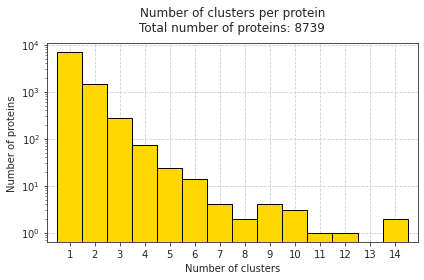

In [92]:
%matplotlib inline
plt.figure(figsize=(6, 4))
plt.grid(linestyle='--', zorder=-2)
plt.hist(clustering['n of clusters'], zorder=2, ec='k', bins=[i for i in range(0, 20, 1)], color='gold')
plt.ylabel("Number of proteins")
plt.xlabel("Number of clusters")
plt.xticks([i+0.5 for i in range(0, 17, 1)], [str(i) for i in range(0, 17, 1)])
plt.xlim([0.6, max(clustering['n of clusters']) + 1.4])
plt.yscale('log')
plt.title("Number of clusters per protein\nTotal number of proteins: " + str(len(clustering)), pad=12)
plt.tight_layout()
# plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/clustering/clusters_per_protein.png", dpi=300)
plt.show()

In [145]:
### PREPARE PROTEINS FOR DOCKING! ###

In [18]:
path_in = "/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/visualization"
path_out = "/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/preparation"
elements = []

for uniprot in tqdm.tqdm(proteins['uniprot']):
# for uniprot in failed:
    
    # if os.path.exists(os.path.join(path_out, uniprot)) is False: os.makedirs(os.path.join(path_out, uniprot))
    # shutil.copyfile(os.path.join(path_in, uniprot, "cluster_REFERENCE.pdb"), os.path.join(path_out, uniprot, "cluster_REFERENCE_" + uniprot + ".pdb"))
    
    inflie = os.path.join(path_out, uniprot,  "cluster_REFERENCE_" + uniprot + ".pdb")
    prepared_prot = os.path.join(path_out, uniprot,  "cluster_REFERENCE_" + uniprot + "_prep.mol2")
    logfile = os.path.join(path_out, uniprot,  "cluster_REFERENCE_" + uniprot + "_log.log")
    
    elements.append([inflie, prepared_prot, logfile])

In [24]:
import sys
sys.path.insert(0, '/aloy/home/acomajuncosa/programs/hpc') #CHANGE THIS PATH TO YOUR HPC PATH!
from hpc import HPC
from sbnb_config import config as cluster_config

scratch_path = "/aloy/scratch/acomajuncosa/MurD/PDB/prep2_/" 
script_path = "/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/scripts/structure_preparation_docking.py"

ncpus = 2
cluster = HPC(**cluster_config)
njobs = len(elements)

cluster_params = {}
cluster_params['job_name'] = 'stprep'
cluster_params["jobdir"] = scratch_path
cluster_params["memory"] = ncpus
cluster_params['cpu'] = ncpus
cluster_params["wait"] = False
cluster_params["elements"] = elements
cluster_params["num_jobs"] = len(elements)


singularity_image = "/aloy/home/acomajuncosa/images/image_2021_09_stprep.simg"
command = "singularity exec {} python {} <TASK_ID> <FILE>".format(
singularity_image,
script_path)

cluster.submitMultiJob(command, **cluster_params)

2022-06-17 18:12:40,881 hpc.HPC      [DEBUG   ] HPC system to use: sge
2022-06-17 18:12:40,883 hpc.HPC      [DEBUG   ] initializing object sge


In [21]:
path = "/aloy/scratch/acomajuncosa/MurD/PDB/prep2"
fail = []

for file in tqdm.tqdm(sorted(os.listdir(path))):
    if '.o' in file:
        with open(os.path.join(path, file), "r") as f:
            for l in f:
                if "error" in l.lower() or "warning" in l.lower() or "protein" in l.lower():
                    print(file)
                    fail.append(file.split(".")[-1])
                    break

  4%|▍         | 354/8780 [00:00<00:04, 1694.29it/s]

stprep.o765674.1062
stprep.o765674.117


 12%|█▏        | 1021/8780 [00:00<00:05, 1365.42it/s]

stprep.o765674.1769
stprep.o765674.1805


 23%|██▎       | 2005/8780 [00:01<00:05, 1205.14it/s]

stprep.o765674.2686


 35%|███▍      | 3043/8780 [00:02<00:05, 1075.67it/s]

stprep.o765674.362


 40%|████      | 3540/8780 [00:02<00:03, 1397.03it/s]

stprep.o765674.3914
stprep.o765674.3915
stprep.o765674.401
stprep.o765674.4063
stprep.o765674.407


 45%|████▌     | 3990/8780 [00:03<00:03, 1380.27it/s]

stprep.o765674.4350


 49%|████▉     | 4290/8780 [00:03<00:03, 1318.59it/s]

stprep.o765674.4699
stprep.o765674.478


 57%|█████▋    | 5017/8780 [00:04<00:03, 1029.14it/s]

stprep.o765674.5428
stprep.o765674.5452


 64%|██████▍   | 5618/8780 [00:04<00:02, 1199.26it/s]

stprep.o765674.5912


 67%|██████▋   | 5906/8780 [00:04<00:02, 1307.98it/s]

stprep.o765674.6151


 71%|███████   | 6194/8780 [00:04<00:01, 1337.66it/s]

stprep.o765674.6497


 91%|█████████ | 7998/8780 [00:06<00:00, 936.45it/s] 

stprep.o765674.8049


100%|██████████| 8780/8780 [00:07<00:00, 1141.62it/s]

stprep.o765674.899


In [3]:
path = "/aloy/scratch/acomajuncosa/MurD/PDB/prep2_/"
fail = []

for file in tqdm.tqdm(sorted(os.listdir(path))):
    if '.o' in file:
        with open(os.path.join(path, file), "r") as f:
            for l in f:
                if "error" in l.lower() or "warning" in l.lower() or "protein" in l.lower():
                    print(file)
                    fail.append(file.split(".")[-1])
                    break

100%|██████████| 39/39 [00:00<00:00, 1543.87it/s]

stprep.o765694.1
stprep.o765694.11
stprep.o765694.12
stprep.o765694.13
stprep.o765694.14
stprep.o765694.15
stprep.o765694.16
stprep.o765694.17
stprep.o765694.18
stprep.o765694.20
stprep.o765694.21
stprep.o765694.22
stprep.o765694.25
stprep.o765694.26
stprep.o765694.28
stprep.o765694.29
stprep.o765694.3
stprep.o765694.31
stprep.o765694.32
stprep.o765694.33
stprep.o765694.4
stprep.o765694.5
stprep.o765694.6
stprep.o765694.8


In [8]:
failing_proteins = ['Q58439', 'Q9HZC0']

In [9]:
print(len(clustering), len(clustering_per_cluster))

for out in failing_proteins:
    clustering = clustering.loc[clustering['protein'] != out].reset_index()
    clustering_per_cluster.loc[clustering_per_cluster['protein'] != out].reset_index()
print(len(clustering), len(clustering_per_cluster))

8739 11275
8737 11275


In [10]:
### GET CLUSTER/POCKET INFO FOR EACH PROTEIN

all_clusters = {}
clusters = {}

for i, j, k in zip(clustering_per_cluster['protein'], clustering_per_cluster['cluster'], clustering_per_cluster['n of structures']):
    if i not in all_clusters:
        all_clusters[i] = {}
    all_clusters[i][j] = k
    
for uni in sorted(all_clusters):
    order = sorted(all_clusters[uni], key=lambda x: all_clusters[uni][x])[::-1][:3]
    clusters[uni] = {}
    for o in order[:3]:
        # if all_clusters[uni][o] > 1:
        clusters[uni][o] = all_clusters[uni][o]

In [11]:
len([i for i in all_clusters for j in all_clusters[i]])

11275

In [12]:
len([i for i in clusters for j in clusters[i]])

11003

In [13]:
pickle.dump(clusters, open("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/clusters.pkl", "wb"))

In [14]:
def calculate_centroid(arr):
    arr = np.array(arr)
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([round(sum_x/length, 3), round(sum_y/length, 3), round(sum_z/length, 3)])

# Get 3D points from ligand centroid
def get_3d_points(file):
    point = PDBParser(QUIET=True).get_structure("point", file)[0]
    return [at.get_coord() for at in point.get_atoms()][0]

In [15]:
### GENERATE CENTROIDS FOR DOCKING

path_to_vis = "/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/visualization"
path_to_reports = "/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/reports"
path_to_prep = "/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/preparation"

for protein in tqdm.tqdm(sorted(clusters)):
    
    # Get report
    report = pickle.load(open(os.path.join(path_to_reports, protein, protein + ".pkl"), "rb"))
    
    # Calculate centroid for each cluster
    for clust_numb in clusters[protein]:
        ctrs = [i for i in report if report[i] == clust_numb]
        ctrs = np.array([get_3d_points(os.path.join(path_to_vis, protein, i)) for i in ctrs])
        x, y, z = calculate_centroid(ctrs)
        x, y, z = str(x), str(y), str(z)
        
        # Write
        centroid = " "*(8-len(x)) + x + " "*(8-len(y)) + y + " "*(8-len(z)) + z
        text = """HEADER\nHETATM    1   C  CTR A   1    """ + centroid + """  1.00  1.00           C\nEND"""
        
        outfile = os.path.join(path_to_prep, protein, "centroid_" + str(clust_numb) + ".pdb")
        with open(outfile, "w") as f:
            f.write(text)
            
        command = 'obabel ' + outfile + " -O " + os.path.join(path_to_prep, protein, "centroid_" + str(clust_numb) + ".sd")
        os.system(command)

100%|██████████| 8739/8739 [37:18<00:00,  3.90it/s]  


In [118]:
### CHECK STRUCTURAL CLASHES

In [42]:

# pickle.load(open("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/reports/P00178/P00178_conflicts.pkl", "rb"))
# path = '/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/reports'
# protein = 'Q9LBX2'
# clusters = pickle.load(open(os.path.join(path, protein, protein + '.pkl'), "rb"))
# numb_clusters = sorted(set([clusters[i] for i in clusters]))
# vis_path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/visualization", protein)

# # Get 3D points from ligand centroid
# def get_3d_points(file):
#     point = PDBParser().get_structure("point", file)[0]
#     return [at.get_coord() for at in point.get_atoms()][0]

# # Get the nonredundant set of pairs ==> (A, B, C, D): (A,B), (A,C), (A,D), (B,C), (B,D), (C,D)
# def get_nonredundant_pairs(ctr):
#     pairs = []
#     for i in ctrs:
#         for j in ctrs:
#             if i != j and " ".join([i, j]) not in pairs and " ".join([j, i]) not in pairs:
#                 pairs.append(" ".join([i, j]))
#     return pairs



# for numb_cluster in numb_clusters:
#     ctrs, loc = [], {} 
    
#     # Get how many centroids are clustered in numb_clustered
#     for ctr in clusters:
#         if clusters[ctr] == numb_cluster:
#             ctrs.append(ctr)
            
#     # Get all pairs of distances
#     pairs = get_nonredundant_pairs(ctr)
#     for ctr in ctrs:
#         loc[ctr] = get_3d_points(os.path.join(vis_path, ctr))
        
#     # Check conflicts for all pairs of centroids
#     c = False
#     for pair in pairs:
#         ctr1, ctr2 = loc[pair.split()[0]], loc[pair.split()[1]]
#         conflict = check_conflict(ctr1, ctr2, os.path.join(vis_path, "cluster_REFERENCE.pdb"))
#         if conflict is True:
#             c = True
#             print(pair)
#             break
#     print(numb_cluster, c)
    
    
# def check_clash(points, locations, minimum=2):
#     dists = np.array([min(i) for i in pairwise_distances(points, locations, metric='euclidean')])
#     if min(dists) < minimum:
#         return True
#     else:
#         return False
    
    
# def check_conflict(loc1, loc2, path_to_st):
    
#     # Load loc from all atoms in st
#     st = PDBParser().get_structure("st", path_to_st)
#     atoms_prot = [i.coord for i in st.get_atoms()]
    
#     # Calculate points to check
#     thr = 1  # point every 1 A
#     incr = np.linalg.norm(loc1-loc2)
#     n_spaces = int(incr/thr) + 2
#     points_to_check = np.linspace(loc1, loc2, n_spaces)
    
#     # Check clashes with points
#     conflict = check_clash(points_to_check, atoms_prot)
    
#     return conflict

/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages

CTR_5XDC_C_IND_0_centroid.pdb CTR_5XDG_A_83U_0_centroid.pdb
0 True


In [363]:
uniprot = elements[0][0]  # uniprot
structures = elements[0][1]  # associated structures
ref_structure = elements[0][2]  # ref structure to make superpositions

# Some functions

# Read trans/rot matrix for alignment (TM-align)
def read_mtx(file):
    f = open(file, "r").readlines()[2:5]
    f = np.array([i.split()[1:] for i in f], dtype='float32')
    t = np.array(f[:,0])
    u = np.array([f[0][1:], f[1][1:], f[2][1:]])
    return t, u

# Get 3D points from ligand centroid
def get_3d_points(file):
    point = PDBParser().get_structure("point", file)[0]
    return [at.get_coord() for at in point.get_atoms()][0]

# Get line to merge pdbs
def get_line_point(file):
    f = open(file, "r").readlines()
    return f[0]

In [364]:
ref_structure

'6A7P_B_9SC'

In [365]:
### 1. CREATE DIRECTORIES

path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/structures")


mtx_path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/mtx", uniprot)
outpath = os.path.join('/aloy/home/acomajuncosa/MurD/GitHub/alignment/pockets', uniprot)
vis_path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/visualization", uniprot)
path_to_aligned_sts = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/aligned_structures/", uniprot)
path_to_reports = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/reports/", uniprot)

if os.path.exists(mtx_path) is False: os.makedirs(mtx_path)
if os.path.exists(outpath) is False: os.makedirs(outpath)
if os.path.exists(vis_path) is False: os.makedirs(vis_path)
if os.path.exists(path_to_aligned_sts) is False: os.makedirs(path_to_aligned_sts)
if os.path.exists(path_to_reports) is False: os.makedirs(path_to_reports)



### 2. EXTRACT & ORGANIZE THE DATA

# Extract the data (st, lig, ctr)
for structure in structures:
    
    pdb = structure.split("_")[0]
    chain = structure.split("_")[1]
    ligand = structure.split("_")[2]
    count = structure.split("_")[3]


    label = "_".join([pdb, chain, ligand])
    
    
    st = label + "/" + label + ".pdb"
    lig = label + "/" + ligand + "_" + count + ".pdb"
    ctr = label + "/" + ligand + "_" + count + "_centroid.pdb"

    tar = tarfile.open(os.path.join(path, pdb[1:3], label + ".tar.gz"), "r")
    tar.extract(st, path=os.path.join(outpath))
    tar.extract(lig, path=os.path.join(outpath))
    tar.extract(ctr, path=os.path.join(outpath))
    tar.close()
    
# Select one st as reference (st2)
shutil.copyfile(os.path.join(outpath, ref_structure, ref_structure + ".pdb"), os.path.join(vis_path, "cluster_REFERENCE.pdb"))

'/aloy/home/acomajuncosa/MurD/GitHub/alignment/MSA/visualization/P02768/cluster_REFERENCE.pdb'

In [366]:
### 3. MAKE STRUCTURAL SUPERPOSITIONS

# Structural superposition against ref (st2)
for structure in structures:
    
    pdb = structure.split("_")[0]
    chain = structure.split("_")[1]
    ligand = structure.split("_")[2]
    count = structure.split("_")[3]
    
    st1 = "_".join(structure.split("_")[:-1])
    count = structure.split("_")[-1]
    
    # Superpose using TM-align
    command = '/aloy/home/acomajuncosa/programs/TM_align/TMalign ' + os.path.join(outpath, st1, st1 + '.pdb') + ' ' + os.path.join(outpath, ref_structure, ref_structure + '.pdb') + ' -m ' + os.path.join(mtx_path, ref_structure + "_" + st1 + ".txt")
    os.system(command)
    

    t, u = read_mtx(os.path.join(mtx_path, ref_structure + "_" + st1 + ".txt"))


    # Protein
    structure = PDBParser().get_structure("st", os.path.join(outpath, st1, st1 + ".pdb"))[0]
    for atom in structure.get_atoms():
        #atom.transform(rotation_matrix, translation_matrix)
        x0, y0, z0 = atom.get_coord()[0], atom.get_coord()[1], atom.get_coord()[2]
        x = t[0] + u[0][0]*x0 + u[0][1]*y0 + u[0][2]*z0
        y = t[1] + u[1][0]*x0 + u[1][1]*y0 + u[1][2]*z0
        z = t[2] + u[2][0]*x0 + u[2][1]*y0 + u[2][2]*z0
        atom.coord = np.array([x, y, z])
    io = PDBIO()
    io.set_structure(structure)
    io.save(os.path.join(outpath, st1, st1 + '_aligned.pdb'))

    label = "_".join([pdb, chain, ligand])
    lig = ligand + "_" + count
    ctr = ligand + "_" + count + "_centroid"

    shutil.copyfile(os.path.join(outpath, st1, st1 + '_aligned.pdb'), os.path.join(path_to_aligned_sts, st1 + '_aligned.pdb'))
    
    
    # Centroid
    structure = PDBParser().get_structure("st", os.path.join(outpath, st1, ctr + ".pdb"))
    for atom in structure.get_atoms():
        # atom.transform(rotation_matrix, translation_matrix)
        x0, y0, z0 = atom.get_coord()[0], atom.get_coord()[1], atom.get_coord()[2]
        x = t[0] + u[0][0]*x0 + u[0][1]*y0 + u[0][2]*z0
        y = t[1] + u[1][0]*x0 + u[1][1]*y0 + u[1][2]*z0
        z = t[2] + u[2][0]*x0 + u[2][1]*y0 + u[2][2]*z0
        atom.coord = np.array([x, y, z])
    io = PDBIO()
    io.set_structure(structure)
    io.save(os.path.join(outpath, st1, ctr + '_aligned.pdb'))
    shutil.copyfile(os.path.join(outpath, st1, ctr + '_aligned.pdb'), os.path.join(vis_path, "CTR_" + st1 + "_" + "_".join(ctr.split("_")[1:]) + ".pdb"))



/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3
  PDBConstructionWarning,
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages

In [369]:
### 4. READ THE COORDINATES FROM ALL CENTROIDS 

labs, coords = [], []

for file in sorted(os.listdir(vis_path)):
    if "centroid" in file and "REFERENCE" not in file:
        labs.append(file)
        coord = get_3d_points(os.path.join(vis_path, file))
        coords.append([coord[0], coord[1], coord[2]])

coords = np.array(coords)
coords_ = list(coords)
labs = np.array(labs)

In [374]:
def check_cond2(cluster_points, max_centroid):
    # Get new centroid
    ctr = calculate_centroid(cluster_points)
    dist = max(pairwise_distances(ctr.reshape(1, -1), cluster_points)[0])
    return dist < max_centroid

def get_min_dist_between_clusters(points1, points2):
    return min([j for i in pairwise_distances(points1, points2) for j in i])

def calculate_centroid(arr):
    arr = np.array(arr)
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([sum_x/length, sum_y/length, sum_z/length])


# coords = coords_
def clustering(coords, min_newpoint, max_centroid):

    # Get info
    coords = {i: j for i, j in zip(range(len(coords)), coords)}
    # clusters = {i: j.reshape(1, -1) for i, j in zip(range(len(coords)), coords)}
    real_clusters = {}
    clust_gen = True
    clust_count = -1

    while clust_gen and len([i for i in coords if i not in real_clusters]) > 1:

        # Get minimum distance between points
        labels = [i for i in coords if i not in real_clusters]
        distances = pairwise_distances([coords[i] for i in coords if i not in real_clusters])
        mindist = {}
        for c1, row in zip(labels, distances):
            for c2, dist in zip(labels, row):
                c1, c2 = str(c1), str(c2)
                if c1 + "_" + c2 not in mindist and c2 + "_" + c1 not in mindist and c1 != c2:
                    mindist[c1 + "_" + c2] = dist

        # Get the first centroid
        minimum = sorted(mindist, key=lambda x: mindist[x])[0]
        # print(mindist[minimum], clust_count+1)
        # print(clust_gen, cont)

        if mindist[minimum] < min_newpoint:
            #print("in!")
            clust_count += 1
            real_clusters[int(minimum.split("_")[0])] = clust_count
            real_clusters[int(minimum.split("_")[1])] = clust_count
            if len([i for i in coords if i not in real_clusters]) > 0:
                clust_gen = True
                cont = True
            else:
                clust_gen = False
                cont = False

        else:
            clust_gen = False
            cont = False

        while cont == True and len([i for i in coords if i not in real_clusters]) > 0:

            cluster_points = np.array([coords[i] for i in real_clusters if real_clusters[i] == clust_count])
            cluster_labels = np.array([i for i in real_clusters if real_clusters[i] == clust_count])
            centroid = calculate_centroid(cluster_points)

            ### Increase cluster
            # Get the min external point to cluster points
            increasing = {}
            labels = np.array([i for i in coords if i not in real_clusters])
            for cluster_label, cluster_point in zip(cluster_labels, cluster_points):
                dist = pairwise_distances(cluster_point.reshape(1, -1), [coords[i] for i in coords if i not in real_clusters])[0]
                ind = dist.argmin()
                increasing[cluster_label] = [dist[ind], labels[ind]]


            increasing = np.array([increasing[i] for i in increasing])
            dist, lab = increasing[:,0], increasing[:,1]
            ind = dist.argmin()
            dist, lab = dist[ind], int(lab[ind])

            # Check condition 1 // cond1
            if dist < min_newpoint:
                cond1 = True
            else:
                cond1 = False


            # Check condition 2 // cond2
            if cond1 == True:
                cluster_points_check = np.array([list(coords[i]) for i in real_clusters if real_clusters[i] == clust_count] + [list(coords[lab])])
                cond2 = check_cond2(cluster_points_check, max_centroid)

            if cond1 == True and cond2 == True:
                real_clusters[lab] = clust_count
            else:
                cont = False

    return real_clusters, clust_count



def assign_outliers(clust_count, real_clusters, coords):        

    clust_count += 1
    coords = {i: j for i, j in zip(range(len(coords)), coords)}

    for i in sorted(coords):
        if i not in real_clusters:
            real_clusters[i] = clust_count
            clust_count += 1
            
    return real_clusters



def pretty_clusters(real_clusters, vis_path, path_to_reports):
    
    clst = {}

    for numb_cluster in set(sorted([real_clusters[i] for i in real_clusters])):
        for st in real_clusters:
            if real_clusters[st] == numb_cluster:
                clst[labs[st]] = numb_cluster
                
    # Pretty print
    for cluster in sorted(set([real_clusters[i] for i in real_clusters])):
        with open(os.path.join(vis_path, "cluster_" + str(cluster) + ".pdb"), "w") as f:
            f.write("HEADER\n")
            for lab in clst:
                if clst[lab] == cluster:
                    l = get_line_point(os.path.join(vis_path, lab))
                    f.write(l)
            f.write("END")

    # Print report(s)
    with open(os.path.join(path_to_reports, uniprot + ".tsv"), "w") as f:
        f.write("\n".join(["\t".join([i,str(clst[i])]) for i in clst]))

    report = {i:clst[i] for i in clst}
    pickle.dump(report, open(os.path.join(path_to_reports, uniprot + ".pkl"), "wb"))

In [380]:
min_newpoint = 5
max_centroid = 18

if len(coords) > 1:

    real_clusters, clust_count = clustering(coords, min_newpoint, max_centroid)
    real_clusters = assign_outliers(clust_count, real_clusters, coords)
    pretty_clusters(real_clusters, vis_path, path_to_reports)

else:
    real_clusters = {}
    real_clusters[0] = 0
    pretty_clusters(real_clusters, vis_path, path_to_reports)

In [ ]:
# # Get the closest residue to all centroids
# close_residues = {}
# protein = PDBParser().get_structure("st", os.path.join(vis_path, "cluster_REFERENCE.pdb"))
# for file in sorted(os.listdir(vis_path)):
#     if "REFERENCE" not in file:
#         lab = "_".join(file.split("_")[:5])
#         coord = get_3d_points(os.path.join(vis_path, file))
#         all_distances = np.array([[distance.euclidean(i.coord, coord), i.get_parent()] for i in protein.get_atoms()], dtype='object')
#         closest_res = sorted(all_distances, key=lambda x: x[0])[0][1]
#         close_residues[lab] = closest_res  

In [339]:
# # MOSCA'S SCRIPT
# chain = ref_structure.split("_")[1]
# distances = []
# for i in tqdm.tqdm(sorted(close_residues)):
#     distances_ = []
#     for j in sorted(close_residues):
#         res1 = str(close_residues[i].get_id()[1])
#         res2 = str(close_residues[j].get_id()[1])
#         if res1 != res2:
#             command = "/aloy/data/programs/pac3/rosa/bin/distances -s 'chain " + chain + " and name CA and (resi " + res1 + " or resi " + res2 + ")' " + os.path.join(vis_path, "cluster_REFERENCE.pdb")
#             r = os.popen(command).read()
#             dist = round(float(r.split("\n")[1].split("\t")[-1]), 3)
#         else:
#             dist = 0
#         distances_.append(dist)
#     distances.append(distances_)

100%|██████████| 44/44 [01:12<00:00,  1.65s/it]


In [310]:
from sklearn.cluster import DBSCAN

In [293]:
# import stat
# os.chdir(vis_path)
# chain = ref_structure.split("_")[1]
# # path_to_jwalk = "/aloy/home/acomajuncosa/programs/Jwalk/Jwalk-master/Jwalk/build/scripts-2.7/jwalk"
# # shutil.copyfile(path_to_jwalk, "./jwalk")
# for i in tqdm.tqdm(sorted(close_residues)):
#     distances_ = []
#     for j in sorted(close_residues):
#         res1 = str(close_residues[i].get_id()[1])
#         res2 = str(close_residues[j].get_id()[1])
#         if res1 != res2:
#             search = "|".join([res1, chain, res2, chain])
#             with open("./list.txt", "w") as file:
#                 file.write(search)
#                 command = path_to_jwalk + " -i cluster_REFERENCE.pdb -xl_list list.txt"
#                 os.system(command)
#             break
#         else:
#             dist = 0
#     break